<a href="https://colab.research.google.com/github/mabataki2/AI-Class/blob/main/Week9/LSTM_TSLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
# -----------------------------------------------------------
# 1. 데이터 로드 및 정규화
# -----------------------------------------------------------
df = pd.read_csv('/content/drive/MyDrive/TSLA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

data = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [3]:
# -----------------------------------------------------------
# 2. 시퀀스 생성 함수
# -----------------------------------------------------------
def make_sequence(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

In [4]:
# -----------------------------------------------------------
# 3. 모델 훈련 함수
# -----------------------------------------------------------
def train_model(model_type, window):
    X, y = make_sequence(data, window)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = tf.keras.Sequential()
    if model_type == 'RNN':
        model.add(tf.keras.layers.SimpleRNN(64, input_shape=(window, 1)))
    elif model_type == 'LSTM':
        model.add(tf.keras.layers.LSTM(64, input_shape=(window, 1)))
    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    test_mse = mean_squared_error(y_test, test_pred)
    full_pred = np.concatenate((train_pred, test_pred), axis=0)

    return model, full_pred, test_mse, y, train_size


In [5]:
# -----------------------------------------------------------
# 4. 모델 훈련
# -----------------------------------------------------------
models = {}
windows = [12, 6]
types = ['RNN', 'LSTM']

for w in windows:
    for t in types:
        print(f"--- {t} 모델 (window={w}) 훈련 시작 ---")
        model, pred, mse, y_scaled, train_size = train_model(t, w)
        models[(t, w)] = {'model': model, 'pred': pred, 'mse': mse, 'y': y_scaled, 'train_size': train_size}
        print(f"✅ {t} (window={w}) 완료 | MSE={mse:.6f}")


--- RNN 모델 (window=12) 훈련 시작 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
✅ RNN (window=12) 완료 | MSE=0.000463
--- LSTM 모델 (window=12) 훈련 시작 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
✅ LSTM (window=12) 완료 | MSE=0.000550
--- RNN 모델 (window=6) 훈련 시작 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
✅ RNN (window=6) 완료 | MSE=0.000498
--- LSTM 모델 (window=6) 훈련 시작 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
✅ LSTM (window=6) 완료 | MSE=0.000533


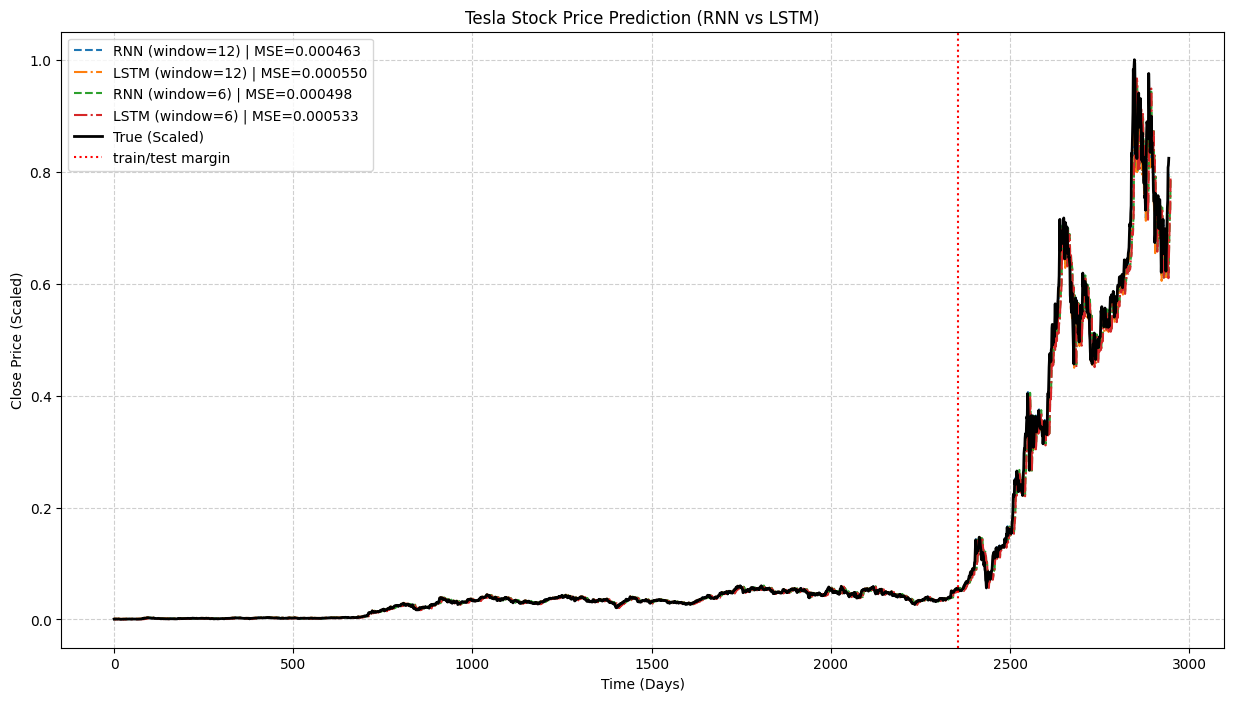

In [6]:
# -----------------------------------------------------------
# 5. 시각화
# -----------------------------------------------------------
plt.figure(figsize=(15, 8))
for (t, w), info in models.items():
    plt.plot(info['pred'], label=f'{t} (window={w}) | MSE={info["mse"]:.6f}',
             linestyle='--' if t=='RNN' else '-.')

any_info = next(iter(models.values()))
plt.plot(any_info['y'], label='True (Scaled)', color='k', linewidth=2)
plt.axvline(x=any_info['train_size'], color='r', linestyle=':', linewidth=1.5, label='train/test margin')

plt.title('Tesla Stock Price Prediction (RNN vs LSTM)')
plt.xlabel('Time (Days)')
plt.ylabel('Close Price (Scaled)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()